In [11]:
import tensorflow as tf
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [12]:
def get_files():
    with tf.name_scope('Get_data_labels'):
        Dz = []
        label_dz = []
        Zw = []
        label_zw = []   
        path = "/Users/shangsuiyue/basictest/"
        for file in os.listdir(path):
            name = file.split(sep='_')
            if name[0] == 'Dz':
                Dz.append(path+file)
                label_dz.append(0)
            elif name[0] == 'Zw':
                Zw.append(path+file)
                label_zw.append(1)
            else:
                pass      
        image_list = np.hstack(( Dz , Zw ))
        label_list = np.hstack(( label_dz , label_zw ))
      
        temp = np.array([image_list,label_list])
        temp = temp.transpose()
        np.random.shuffle(temp)
        image_list = list(temp[:,0])
        label_list = list(temp[:,1])
        label_list = [int(i) for i in label_list]      
      # label_list=tf.one_hot(label_list,2,1,0,-1)
    return image_list, label_list  

In [13]:
def get_batch(image,label,image_W,image_H,batch_size,capacity):
    #use tf.cast() to convert the type
    image = tf.cast(image,tf.string)
    label = tf.cast(label,tf.int32)

    #queue
    input_queue = tf.train.slice_input_producer([image,label])
    
    #Decode a JPEG-encoded image to a uint8 tensor.
    label = input_queue[1]
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents,channels=3)
    #resize
    image = tf.image.resize_image_with_crop_or_pad(image,image_W,image_H)
    
    #standardization
    image = tf.image.per_image_standardization(image)
   

    image_batch,label_batch = tf.train.batch([image,label],batch_size = batch_size,num_threads=16,capacity = capacity)

    label_batch = tf.reshape(label_batch,[batch_size])
    return image_batch,label_batch
    

label: 1


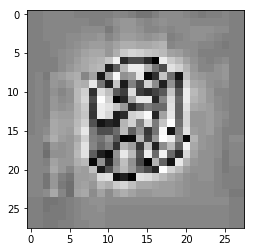

label: 1


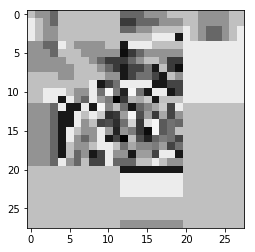

label: 0


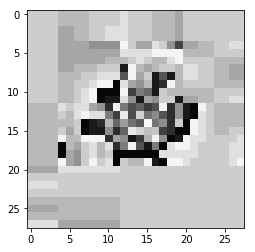

label: 0


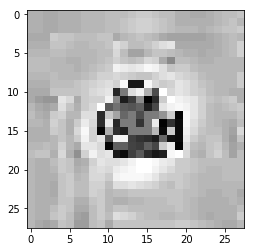

label: 0


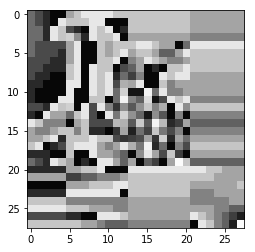

label: 1


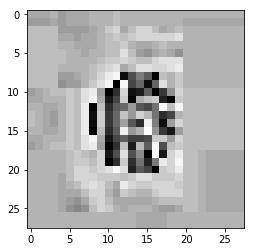

label: 1


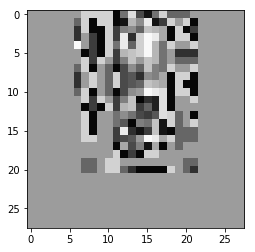

label: 1


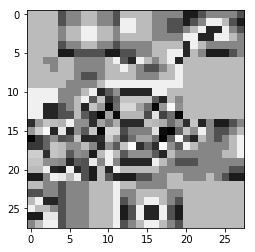

label: 0


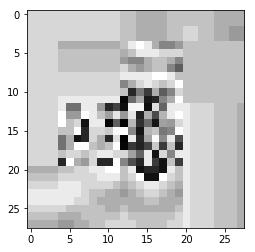

label: 0


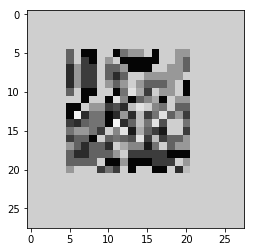

In [14]:
# Show and Check images

BATCH_SIZE = 5
CAPACITY = 64
IMG_W = 28
IMG_H = 28

image_list,label_list = get_files()
image_batch,label_batch = get_batch(image_list,label_list,IMG_W,IMG_H,BATCH_SIZE,CAPACITY)

with tf.Session() as sess:
    i=0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord = coord)
    try:
        while not coord.should_stop() and i<2:
        #提取出两个batch的图片并可视化。
            img,label = sess.run([image_batch,label_batch])

            for j in np.arange(BATCH_SIZE):
                print('label: %d'%label[j])
                plt.imshow(img[j,:,:,:])
                plt.show()
            i+=1
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)

In [15]:
# Multi_layer model
def inference(images, batch_size, n_classes):
    
    # conv1, shape = [kernel_size, kernel_size, channels, kernel_numbers]
    with tf.variable_scope("conv1") as scope:
        weights = tf.get_variable("weights",
                                  shape=[3, 3, 3, 16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(images, weights, strides=[1, 1, 1, 1], padding="SAME")
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name="conv1")

    # pool1 && norm1
    with tf.variable_scope("pooling1_lrn") as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                               padding="SAME", name="pooling1")
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75, name='norm1')

    # conv2
    with tf.variable_scope("conv2") as scope:
        weights = tf.get_variable("weights",
                                  shape=[3, 3, 16, 16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1, 1, 1, 1], padding="SAME")
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name="conv2")

    # pool2 && norm2
    with tf.variable_scope("pooling2_lrn") as scope:
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                               padding="SAME", name="pooling2")
        norm2 = tf.nn.lrn(pool2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75, name='norm2')

    # full-connect1
    with tf.variable_scope("fc1") as scope:
        reshape = tf.reshape(norm2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable("weights",
                                  shape=[dim, 128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc1 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name="fc1")

    # full_connect2
    with tf.variable_scope("fc2") as scope:
        weights = tf.get_variable("weights",
                                  shape=[128, 128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases, name="fc2")

    # softmax
    with tf.variable_scope("softmax_linear") as scope:
        weights = tf.get_variable("weights",
                                  shape=[128, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[n_classes],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name="softmax_linear")
    return softmax_linear

In [16]:
def losses(logits, labels):
    with tf.variable_scope("loss") as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                                       labels=labels, name="xentropy_per_example")
        loss = tf.reduce_mean(cross_entropy, name="loss")
        tf.summary.scalar(scope.name + "loss", loss)
    return loss

In [17]:
def trainning(loss, learning_rate):
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

In [18]:
def evaluation(logits, labels):
    with tf.variable_scope("accuracy") as scope:
        correct = tf.nn.in_top_k(logits, labels, 1)
        correct = tf.cast(correct, tf.float16)
        accuracy = tf.reduce_mean(correct)
        tf.summary.scalar(scope.name + "accuracy", accuracy)
    return accuracy

In [19]:
def run_training():
    logs_train_dir = '/Users/shangsuiyue/'
    train,train_label = get_files()
    train_batch,train_label_batch = get_batch(train,train_label,
                                                         IMG_W,
                                                         IMG_H,
                                                         BATCH_SIZE,
                                                         CAPACITY)
    train_logits =inference(train_batch,BATCH_SIZE,N_CLASSES)
    train_loss = losses(train_logits,train_label_batch)
    train_op = trainning(train_loss,learning_rate)
    train_acc = evaluation(train_logits,train_label_batch)

    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    train_writer = tf.summary.FileWriter(logs_train_dir,sess.graph)
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess = sess,coord = coord)

    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                break
            _,tra_loss,tra_acc = sess.run([train_op,train_loss,train_acc])
            if step % 50 == 0:
                print('Step %d,train loss = %.2f,train occuracy = %.2f'%(step,tra_loss,tra_acc))
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str,step)

            if step % 100 ==0 or (step +1) == MAX_STEP:
                checkpoint_path = os.path.join(logs_train_dir,'model.ckpt')
                saver.save(sess,checkpoint_path,global_step = step)
                

    except tf.errors.OutOfRangeError:
        print('Done training epoch limit reached')
    finally:
        coord.request_stop()

    coord.join(threads)
    sess.close()

In [20]:
# Parameters
N_CLASSES = 2  # classification
IMG_W = 28     # Image size
IMG_H = 28
BATCH_SIZE = 8 # Batch size
CAPACITY = 64
MAX_STEP = 10000 # Iteration
learning_rate = 0.0001




In [21]:
# Training the model
tf.reset_default_graph()
run = run_training()

Step 0,train loss = 0.69,train occuracy = 0.38
Step 50,train loss = 0.67,train occuracy = 0.50
Step 100,train loss = 0.29,train occuracy = 1.00
Step 150,train loss = 0.07,train occuracy = 1.00
Step 200,train loss = 0.23,train occuracy = 0.88
Step 250,train loss = 0.03,train occuracy = 1.00
Step 300,train loss = 0.10,train occuracy = 0.88
Step 350,train loss = 0.03,train occuracy = 1.00
Step 400,train loss = 0.01,train occuracy = 1.00
Step 450,train loss = 0.01,train occuracy = 1.00
Step 500,train loss = 0.32,train occuracy = 0.88
Step 550,train loss = 0.00,train occuracy = 1.00
Step 600,train loss = 0.01,train occuracy = 1.00
Step 650,train loss = 0.24,train occuracy = 0.88
Step 700,train loss = 0.03,train occuracy = 1.00
Step 750,train loss = 0.00,train occuracy = 1.00
Step 800,train loss = 0.01,train occuracy = 1.00
Step 850,train loss = 0.27,train occuracy = 0.88
Step 900,train loss = 0.05,train occuracy = 1.00
Step 950,train loss = 0.01,train occuracy = 1.00
Step 1000,train loss = 

Step 8250,train loss = 0.00,train occuracy = 1.00
Step 8300,train loss = 0.00,train occuracy = 1.00
Step 8350,train loss = 0.00,train occuracy = 1.00
Step 8400,train loss = 0.00,train occuracy = 1.00
Step 8450,train loss = 0.00,train occuracy = 1.00
Step 8500,train loss = 0.00,train occuracy = 1.00
Step 8550,train loss = 0.00,train occuracy = 1.00
Step 8600,train loss = 0.00,train occuracy = 1.00
Step 8650,train loss = 0.00,train occuracy = 1.00
Step 8700,train loss = 0.00,train occuracy = 1.00
Step 8750,train loss = 0.00,train occuracy = 1.00
Step 8800,train loss = 0.00,train occuracy = 1.00
Step 8850,train loss = 0.00,train occuracy = 1.00
Step 8900,train loss = 0.00,train occuracy = 1.00
Step 8950,train loss = 0.00,train occuracy = 1.00
Step 9000,train loss = 0.00,train occuracy = 1.00
Step 9050,train loss = 0.00,train occuracy = 1.00
Step 9100,train loss = 0.00,train occuracy = 1.00
Step 9150,train loss = 0.01,train occuracy = 1.00
Step 9200,train loss = 0.00,train occuracy = 1.00
